# Analyzing Atrato's Portuguese Migrants 🇵🇹

In [75]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as gp
import seaborn as sns
%matplotlib inline

In [76]:
df = pd.read_excel('atrato-data.xlsx', converters={"naturality_city_id": str, "naturality_state_id":str})
df = df[df.nationality=="Portuguese"].reset_index(drop=True)

## Demographics

In [77]:
display("Total of Portuguese migrants:{}".format(len(df)))

'Total of Portuguese migrants:199'

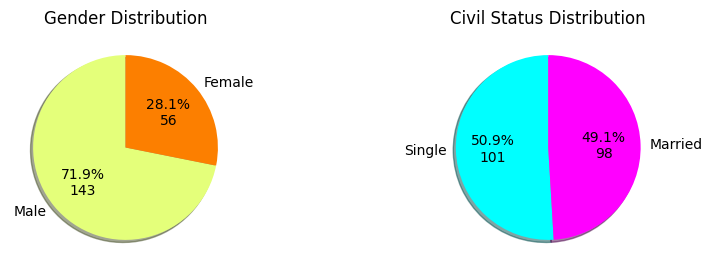

In [78]:
fig, axes = plt.subplots(ncols=2)

gender = df["gender"].to_frame("Gender").value_counts().to_frame("Total")
gender.plot.pie(title="Gender Distribution", figsize=(10,3), cmap="Wistia",y='Total',ylabel='',ax=axes[0],
                autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(df)*prct_value/100)),
                shadow=True, startangle=90, labels=["Male","Female"]).get_legend().remove()

civil_status = df["civil-status"].to_frame("Civil Status").value_counts().to_frame("Total")
civil_status.plot.pie(title="Civil Status Distribution", figsize=(10,3), cmap="cool",
                      autopct=(lambda prct_value: '{:.1f}%\n{:.0f}'.format(prct_value,len(df)*prct_value/100)),
                      shadow=True, startangle=90, labels=["Single","Married"], y='Total', ylabel='',
                      ax=axes[1]).get_legend().remove()

In [79]:
years= df['years'].dropna().astype(int)
months = df['months'].dropna().astype(int)
no_age = df[df['years'].isna() & df['months'].isna()]
print("Total of passengers with age:", len(years)+len(months))
print("Total of passengers without age:", len(no_age))

Total of passengers with age: 194
Total of passengers without age: 5


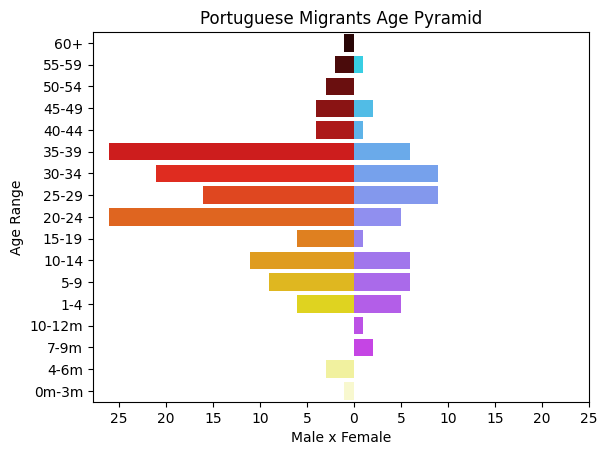

In [80]:
male_infants = df[df.gender=="M"].months.dropna().astype(int).value_counts(bins=[0,3,6,9,12]) .sort_index(ascending=False)
female_infants = df[df.gender=="F"].months.dropna().astype(int).value_counts(bins=[0,3,6,9,12]).sort_index(ascending=False)
male_general = df[df.gender=="M"].years.dropna().astype(int)\
                         .value_counts(bins=[0,4,9,14,19,24,29,34,39,44,49,54,59,80]).sort_index(ascending=False)
female_general = df[df.gender=="F"].years.dropna().astype(int)\
                         .value_counts(bins=[0,4,9,14,19,24,29,34,39,44,49,54,59,80]).sort_index(ascending=False)

pyramid = pd.DataFrame()
pyramid["male"] = pd.concat([male_general,male_infants]); pyramid["male"] = pyramid["male"] * -1;
pyramid["female"] = pd.concat([female_general,female_infants])
pyramid["age"] = ['60+','55-59', '50-54', '45-49', '40-44','35-39','30-34', '25-29',
                  '20-24', '15-19', '10-14', '5-9', '1-4','10-12m','7-9m','4-6m','0m-3m']
pyramid = pyramid.reset_index(drop=True)

male_axis = sns.barplot(x='male', y='age', data=pyramid, order=pyramid["age"], palette="hot");
female_axis = sns.barplot(x='female', y='age', data=pyramid, order=pyramid["age"], palette="cool");
plt.title("Portuguese Migrants Age Pyramid");
plt.xticks(ticks=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25],
           labels=['25', '20', '15', '10', '5','0', '5', '10', '15', '20', '25']);
plt.xlabel("Male x Female"); plt.ylabel("Age Range");

### Naturality

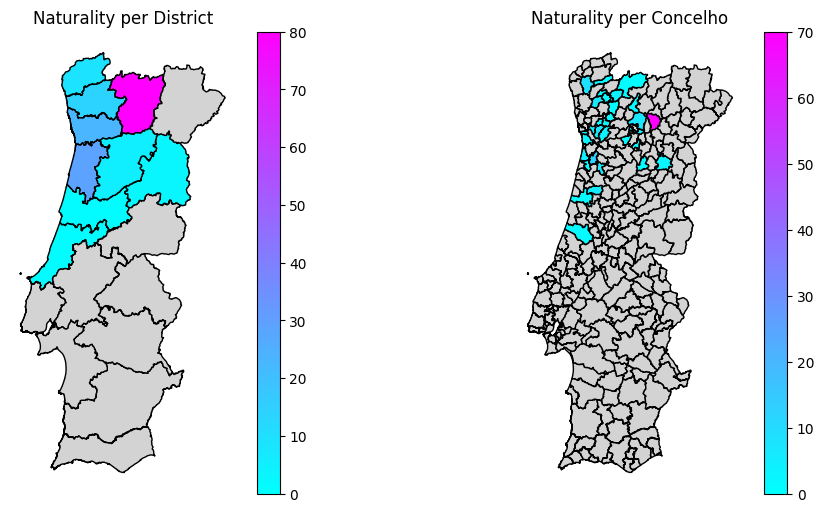

In [81]:
distritos_data=df.naturality_state_id.dropna().reset_index(drop=True).value_counts().to_frame("count")
distritos_data.reset_index(inplace=True)
distritos_data = distritos_data.rename(columns = {'index':'DI'})
distritos_data["DI"] = distritos_data["DI"].astype(str)
distritos_geodata = gpd.read_file("distritos.geojson")

concelhos_data=df.naturality_city_id.dropna().reset_index(drop=True).value_counts().to_frame("count")
concelhos_data.reset_index(inplace=True)
concelhos_data = concelhos_data.rename(columns = {'index':'DICO'})
concelhos_data["DICO"] = concelhos_data["DICO"].astype(str)
concelhos_geodata = gpd.read_file("concelhos.geojson")

fig2, axes = plt.subplots(ncols=2, figsize=(12, 6))
distritos_map = distritos_geodata.merge(distritos_data, how='left', on='DI')
distritos_map.plot(column = "count",cmap="cool", vmax=80, vmin=0, ax=axes[0], legend=True, edgecolor="black",
                   missing_kwds= dict(color = "lightgrey",));

concelhos_map = concelhos_geodata.merge(concelhos_data, how='left', on='DICO')
concelhos_map.plot(column = "count",cmap="cool", vmax=70, vmin=0, ax=axes[1],
                    legend=True, edgecolor="black", missing_kwds= dict(color = "lightgrey",));
axes[0].axis("off"); axes[1].axis("off");
axes[0].title.set_text("Naturality per District"); axes[1].title.set_text("Naturality per Concelho");

## Travel

In [82]:
distritos_geodata = gpd.read_file("distritos.geojson")
distritos_data = pd.read_csv("distritos_passaportes.csv", converters={"DI": str})

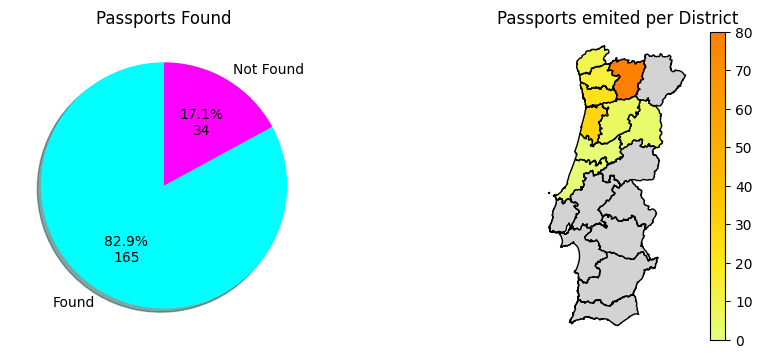

,0,1,2,3,4,5,6,7,8
distrito,Vila Real,Aveiro,Porto,Braga,Viana do Castelo,Viseu,Guarda,Coimbra,Leria
passaportes,81,29,23,14,9,5,3,1,1


In [83]:
fig, axes = plt.subplots(ncols=2)

passport = df["found_passport"].to_frame("Passports Found").value_counts().to_frame("Total")
passport.plot.pie(title="Passports Found", figsize=(10,4), cmap="cool",ax=axes[0], ylabel='',
                autopct=(lambda prct_value: "{:.1f}%\n{:.0f}".format(prct_value,len(df)*prct_value/100)),
                shadow=True, startangle=90, labels=["Found","Not Found"], y="Total").get_legend().remove()
plt.title("Passports emited per District")
distritos_map = distritos_geodata.merge(distritos_data, on="DI")
distritos_map.plot(column = "passaportes",cmap="Wistia",figsize=(15,4), vmax=80, vmin=0, ax=axes[1],
                   legend=True, edgecolor="black", missing_kwds= dict(color = "lightgrey",))
plt.axis("off")
plt.show()

dd = distritos_data.copy()
dd["passaportes"]=dd["passaportes"].astype("Int64")
dd =dd.dropna().sort_values(by="passaportes", ascending=False).drop(columns="DI").reset_index(drop=True)
display(dd.T)

### Embarkation

In [101]:
embarked = df.query("embarked == 'Yes'")
not_embarked = df.query("embarked == 'No'")
print("Out of the {} Portuguese in boarding lists, {} Portuguese embarked and {} did not.\nThey all embarked in the Port of Lisbon."
      .format(len(df), len(embarked), len(not_embarked)))

Out of the 199 Portuguese in boarding lists, 193 Portuguese embarked and 6 did not.
They all embarked in the Port of Lisbon.


In [99]:
solo = embarked["solo_id"].dropna().astype(int).nunique()
families = embarked["family_id"].dropna().astype(int).nunique()
print("The embarked passengers were made up of {} families and {} solo passengers."
      .format(families, solo))

The embarked passengers were made up of 32 families and 87 solo passengers.
